# Ising Model

![title](figs/ising_model.png)

In this project you will use the Metropolis algorithm to investigate ferromagnetism using a simplified model of the spin‑spin interactions known as the [Ising model](https://en.wikipedia.org/wiki/Ising_model). In the Ising model we treat the magnet as a set of spins on fixed lattice sites in two dimensions. The remarkably simple model predicts many features of real ferromagnetic materials such as second order phase transitions in temperature ([Curie point](https://en.wikipedia.org/wiki/Curie_temperature)).

Suppose we have an $N$ by $N$ 2D lattice, for a total of $N^2$ sites. The energy of the system is written
$$
E = - \sum_{(ij)}{s_i s_j}
$$
where $(ij)$ is the sum over nearest neighbour pairs of spins, four total in the 2D case. 

In order to calculate an observable of the system such as the magnetisation (average spin value $ M = \frac{1}{N^2} \sum s_i $), we need to calculate the [canonical ensemble](https://en.wikipedia.org/wiki/Canonical_ensemble) of the system at a given temperature, and then take the average $\langle M \rangle = \overline{M}$ over many microstates. Therefore, we need an algorithm which will generate lattice configurations according to the [Boltzman distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution) at temperature $T$
$$
P(\text{Lattice} ; E) = \frac{1}{Z} e^{-E / T}
$$

Don't worry if the physics behind this is unfamiliar, its really not important. The main idea here is that we have a high dimensional function $E$ (energy) of $N^2$ parameters (spin). And we want to calculate (or estimate) the probability distribution over these parameters according to $P(E)$. 

## Metropolis Algorithm

The [Metropolis algorithm](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) is a Markov-Chain Monte-Carlo method for obtaining a sequence of random samples that is guaranteed to converge to a target distribution. In the last exercise using pure Monte-Carlo, each sample was generated independently with $x,y \in [0,1]$. 

With the Metropolis algorithm, we perform local (small) updates on an initial sample and then choose to probabilistically accept or reject the new sample. If we accept the sample, we add it to our chain and then repeat the process. The intuition with this algorithm is that most of the chain should have lattices with low energy, but we still want some configurations with a high energy to match the desired Boltzmann distribution.

The metropolis algorithm for evolving the lattice microstates is as follows
1. Select a spin. Calculate $ \Delta E $ to flip it.
3. Select a random number $p \in [0,1] $.
4. If $ \exp(- \Delta E / T ) > p $, flip the spin.

This process is repeated for all $N^2$ spins, after which constitutes a single $\text{Monte Carlo time step}$. The newly calculated lattice is then added to a list of Markov-Chain samples. 

To calculate an observable such as the magnetisation, we simply take the mean value of the magnetisation for each sample in the list.
$$
\langle M \rangle = \frac{1}{n_{\text{samples}}} \sum_{t=0}^{\text{samples}} M_t 
$$
$$
M_t = \frac{1}{N^2} \sum_i s_i 
$$

Here is a plot of a Markov-Chain sequence where we calculate the magnetisation of 1000 samples and take the mean of the entire chain.
![mags](figs/magnetisation.png)

## Phase Diagram

Our main goal is to observe a [phase transition](https://en.wikipedia.org/wiki/Phase_transition) in the Ising model. To do this we have to calculate the (absolute) mean magnetisation $| \langle M \rangle |$ for a range of different temperatures. Plotting these on a graph we hope to see a discontinuity where the magnetisation suddenly drops to 0. 

![phase_transition](figs/phase_transition.png)

For reference we have also plotted the [analytical value](https://en.wikipedia.org/wiki/Ising_model#Two_dimensions) for the critical temperature $ T_c = 2/\ln(1+\sqrt(2)) \approx 2.26918 $.

It is your task to implement this algorithm and create a similar phase diagram. Start with a small $N=10$ lattice and see how the phase diagram compares against larger lattices. Try to generate at least $1,000$ samples for each temperature.

## Extension (Optimisations)

The Metropolis algorithm for the Ising model can be computed thousands of times faster using an optimised algorithm that exploits the symmetry of the model. The 'checkerboard' algorithm is described in this [paper](https://arxiv.org/pdf/1906.06297.pdf) and can be implemented in python with not too much extension. Try to use np.roll or jax.roll for GPU acceleration and measure the performance difference. 

In [99]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

CRITICAL_TEMP = 2.26918

In [100]:
def magnetisation(lattice):
    return np.sum(lattice) / lattice.size


# return i in the lattice with periodic boundary conditions
def boundary_conditions(n, i):
    i = n - 1 if i < 0 else i
    i = 0 if i > n - 1 else i

    return i


def delta_energy(lattice, i, j):
    flipped_spin = -1 * lattice[i][j]

    idx_above = boundary_conditions(n, j + 1)
    idx_below = boundary_conditions(n, j - 1)
    idx_left = boundary_conditions(n, i - 1)
    idx_right = boundary_conditions(n, i + 1)

    neighbour_sum = lattice[i][idx_above] + lattice[i][idx_below] + lattice[idx_left][j] + lattice[idx_right][j]

    init_energy = - lattice[i][j] * neighbour_sum
    new_energy = - flipped_spin * neighbour_sum

    return new_energy - init_energy


def metropolis_update(lattice, temperature):
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):

            if math.exp(-delta_energy(lattice, i, j) / temperature) > random.random():
                # flip the spin
                lattice[i][j] *= -1


In [101]:
steps = 500
n = 30
temperature = 2.1

lattice = np.ones((n, n))
mags = []

for t in range(steps):
    metropolis_update(lattice, temperature)
    mags.append(magnetisation(lattice))



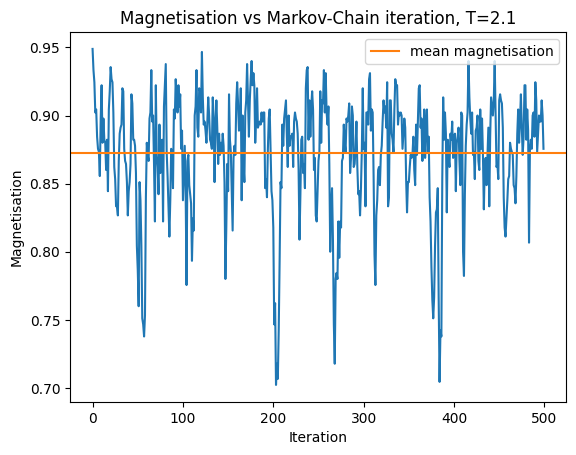

In [102]:
plt.plot(mags)
plt.axhline(np.mean(mags), color='tab:orange', label='mean magnetisation')
plt.xlabel('Iteration')
plt.ylabel('Magnetisation')
plt.title('Magnetisation vs Markov-Chain iteration, T={}'.format(temperature))
plt.legend(loc='upper right')
# plt.show()
# plt.savefig('figs/magnetisation.png')

In [86]:
steps = 1000
n = 10

temperatures = np.arange(0.1, 4, 0.2)
mean_magnetisations = []

for temp in temperatures:
    lattice = np.ones((n, n))
    mags = []

    for t in range(steps):
        metropolis_update(lattice, temp)
        mags.append(magnetisation(lattice))

    mean_mag = np.abs(np.mean(mags))
    mean_magnetisations.append(mean_mag)


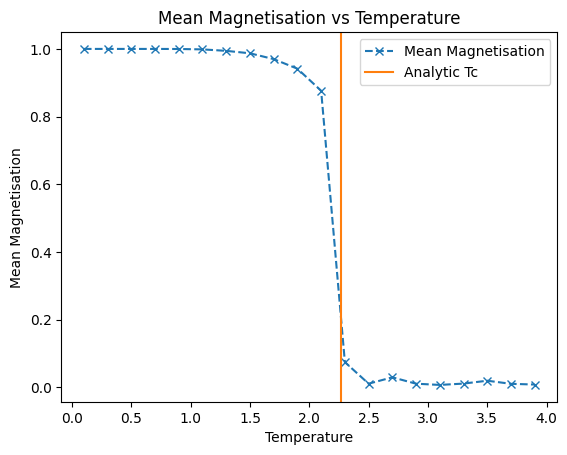

In [88]:
plt.plot(temperatures, mean_magnetisations, label='Mean Magnetisation', linestyle = '--', marker='x')
plt.axvline(CRITICAL_TEMP, color='tab:orange', label='Analytic Tc')
plt.xlabel('Temperature')
plt.ylabel('Mean Magnetisation')
plt.title('Mean Magnetisation vs Temperature')
plt.legend(loc='upper right')
plt.show()


Now lets use the optimised algorithm with checkerboard lattice where we do half updates vectorised

In [27]:
class Ising:
    def __init__(self, n, temperature):
        # n must be even
        self.n = n if n % 2 == 0 else n - 1
        self.temperature = temperature

        self.lattice1 = np.ones((self.n, self.n // 2))
        self.lattice2 = np.ones((self.n, self.n // 2))

    def magnetisation(self):
        return np.sum(self.lattice1 + self.lattice2) / self.n ** 2

    def delta_energy(self):
        neighbour_sum = np.copy(self.lattice2)
        neighbour_sum += np.roll(self.lattice2, (-1, 0), axis=(1, 0))
        neighbour_sum += np.roll(self.lattice2, (0, 1), axis=(1, 0))
        neighbour_sum += np.roll(self.lattice2, (0, -1), axis=(1, 0))

        init_energy = - self.lattice1 * neighbour_sum
        new_energy = self.lattice1 * neighbour_sum

        return new_energy - init_energy

    def grid_metropolis_update(self):
        # lattice1 half-update
        threshold = np.random.random((self.n, self.n // 2))
        flip_spin = np.exp(-self.delta_energy() / self.temperature) > threshold
        self.lattice1 = np.where(flip_spin, -self.lattice1, self.lattice1)

        switch = self.lattice1
        self.lattice1 = self.lattice2
        self.lattice2 = switch


In [55]:
def get_phase_diagram(n, temperatures, steps):    
    mean_magnetisations = []
    
    for temperature in temperatures:
        ising = Ising(n=n, temperature=temperature)
        mags = []
        for t in range(steps):
            ising.grid_metropolis_update()
    
            mags.append(ising.magnetisation())
    
        mean_magnetisations.append(np.mean(np.abs(mags)))
    
    return mean_magnetisations

In [93]:
temperatures = np.arange(0.5, 4, 0.1)
mean_magnetisations = get_phase_diagram(n = 200, temperatures = temperatures, steps = 10000)

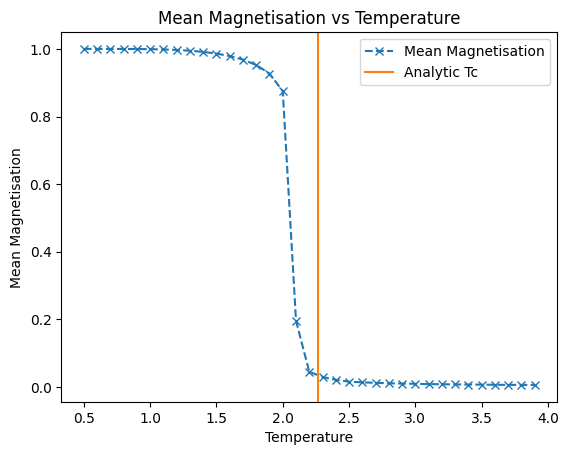

In [94]:
plt.plot(temperatures, mean_magnetisations, label='Mean Magnetisation', linestyle = '--', marker='x')
plt.axvline(CRITICAL_TEMP, color='tab:orange', label='Analytic Tc')
plt.xlabel('Temperature')
plt.ylabel('Mean Magnetisation')
plt.title('Mean Magnetisation vs Temperature')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('figs/phase_transition.png')

Now lets do the plot for $n=10$, $n=50$, and $n=200$ sized lattices so we can see the finite lattice size effects

In [70]:
temperatures = np.arange(1, 4, 0.1)
mean_magnetisations = []
mean_magnetisations.append(get_phase_diagram(n = 10, temperatures = temperatures, steps = 2000))
mean_magnetisations.append(get_phase_diagram(n = 50, temperatures = temperatures, steps = 2000))
mean_magnetisations.append(get_phase_diagram(n = 200, temperatures = temperatures, steps = 2000))

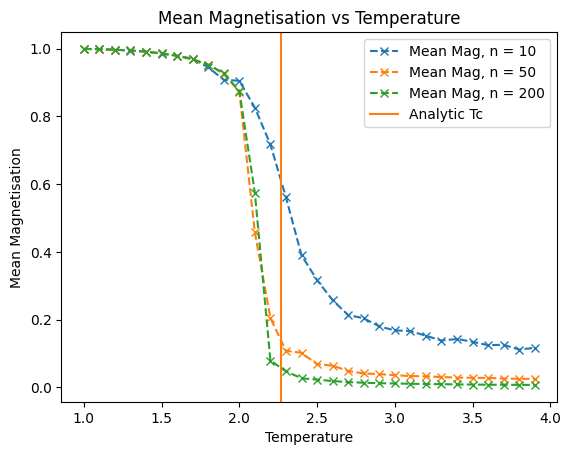

In [71]:
plt.plot(temperatures, mean_magnetisations[0], label='Mean Mag, n = 10', linestyle = '--', marker='x')
plt.plot(temperatures, mean_magnetisations[1], label='Mean Mag, n = 50', linestyle = '--', marker='x')
plt.plot(temperatures, mean_magnetisations[2], label='Mean Mag, n = 200', linestyle = '--', marker='x')
plt.axvline(CRITICAL_TEMP, color='tab:orange', label='Analytic Tc')
plt.xlabel('Temperature')
plt.ylabel('Mean Magnetisation')
plt.title('Mean Magnetisation vs Temperature')
plt.legend(loc='upper right')
plt.show()


We can see the $n=200$ sized lattice has the sharpest phase transition.